# San Diego Housing and Transit Integration Map

**Step 3: Integrated Visualization**

This notebook creates a comprehensive map of San Diego neighborhoods colored by various metrics with transit data overlaid.

Building on:
1. Transit density analysis (geocoding)
2. ZHVI data cleaning and seasonal analysis
3. Final integrated spatial visualization

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


## Data Loading and Preprocessing

In [2]:
# Load the datasets
print("Loading datasets...")

# Load ZHVI data
zhvi_df = pd.read_csv("sd_zhvi_2000_to_2025_nhbd.csv")
zhvi_df.drop(['RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName'], axis=1, inplace=True)

print(f"ZHVI data shape: {zhvi_df.shape}")
zhvi_df.head()

Loading datasets...
ZHVI data shape: (113, 306)


,RegionID,SizeRank,RegionName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,...,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31,2024-11-30,2024-12-31,2025-01-31,2025-02-28,2025-03-31
0,116625,90,Mira Mesa,193881.7585,194840.0815,195903.4942,198352.4132,200938.8613,204180.0619,207701.5108,...,1046746.397,1051713.196,1054413.072,1057080.913,1057115.586,1056057.281,1054485.277,1052457.096,1050504.472,1046568.637
1,117557,187,Rancho Penasquitos,276300.6498,277465.6004,278785.8929,281830.0231,285119.0125,289549.6017,294547.4396,...,1450380.875,1458144.232,1459419.574,1460119.166,1457301.759,1454203.141,1450405.007,1448253.763,1448123.563,1445833.232
2,273140,204,Carmel Valley,378712.6201,380143.9748,381913.8558,385808.6038,390122.3678,395477.2991,401717.6938,...,1943494.554,1947691.501,1947646.537,1949456.924,1953104.658,1959503.760,1968405.118,1977300.502,1987320.717,1994149.151
3,118673,207,University City,240596.5743,241378.2108,242623.4635,245345.9527,248520.5426,252322.8539,256613.3426,...,1042178.257,1044426.072,1043920.893,1043090.010,1040771.071,1038827.183,1037928.809,1037081.718,1038156.197,1037566.337
4,275127,253,Rancho Bernardo,227516.4417,228299.6955,229173.7764,231434.1174,233961.9119,237313.1689,241015.7291,...,1020552.731,1024780.848,1025505.028,1025162.413,1023944.381,1024404.047,1026352.719,1028927.961,1030551.993,1028547.286


In [3]:
# Load transit stops data
transit_df = pd.read_csv("transit_stops_datasd.csv")
transit_df = transit_df[transit_df['stop_agncy'] == 'MTS']
transit_df = transit_df.drop(['stop_uid', 'stop_lat', 'stop_lon', 'stop_agncy', 'stop_code', 'stop_id', 'wheelchair', 'intersec', 'stop_place', 'parent_sta'], axis=1)

print(f"Transit data shape: {transit_df.shape}")
transit_df.head()

Transit data shape: (4394, 4)


,objectid,stop_name,lat,lng
0,1,11th Ave & Broadway,32.716263,-117.154637
1,2,12th & Imperial Station,32.705997,-117.153366
2,3,12th & Imperial Station Bayside,32.705224,-117.154306
3,4,12th & Imperial Transit Center,32.705680,-117.152863
4,5,24th Street Station,32.661849,-117.108005


In [4]:
# Create GeoDataFrame for transit stops
transit_gdf = gpd.GeoDataFrame(
    transit_df, 
    geometry=gpd.points_from_xy(x=transit_df.lng, y=transit_df.lat), 
    crs="EPSG:4326"
)

print(f"Loaded {len(transit_gdf)} transit stops")
transit_gdf.head()

Loaded 4394 transit stops


,objectid,stop_name,lat,lng,geometry
0,1,11th Ave & Broadway,32.716263,-117.154637,POINT (-117.15464 32.71626)
1,2,12th & Imperial Station,32.705997,-117.153366,POINT (-117.15337 32.706)
2,3,12th & Imperial Station Bayside,32.705224,-117.154306,POINT (-117.15431 32.70522)
3,4,12th & Imperial Transit Center,32.705680,-117.152863,POINT (-117.15286 32.70568)
4,5,24th Street Station,32.661849,-117.108005,POINT (-117.10801 32.66185)


## Neighborhood Boundary Processing

In [5]:
# Load neighborhood shapefiles
try:
    neighborhoods = gpd.read_file("SDPD_Beats_shapefile/SDPD_Beats.shp")
    zones = gpd.read_file("Zoning_Base_SD_shapefile/Zoning_Base_SD.shp")
    
    # Remove restricted zones (AR-1-1, AG-1-1, AR-1-2)
    uncounted_zones = zones[zones["ZONE_NAME"].isin(["AR-1-1", "AG-1-1", "AR-1-2"])]
    
    # Convert to consistent CRS
    transit_gdf = transit_gdf.to_crs(epsg=26911)
    neighborhoods = neighborhoods.to_crs(epsg=26911)
    uncounted_zones = uncounted_zones.to_crs(epsg=26911)
    
    # Clean neighborhoods by removing restricted zones
    neighborhoods_cleaned = gpd.overlay(neighborhoods, uncounted_zones, how='difference')
    
    print(f"Loaded {len(neighborhoods_cleaned)} cleaned neighborhoods")
    shapefile_success = True
    
except Exception as e:
    print(f"Could not load shapefiles: {e}")
    print("Creating simplified neighborhood boundaries from existing data...")
    neighborhoods_cleaned = None
    shapefile_success = False

Loaded 135 cleaned neighborhoods


## Transit Density Analysis

In [6]:
# Calculate transit density (stops within 850m of neighborhood centroids)
if neighborhoods_cleaned is not None:
    neighborhoods_cleaned["buffer_850m"] = neighborhoods_cleaned.geometry.centroid.buffer(850)
    buffered = gpd.GeoDataFrame(neighborhoods_cleaned, geometry="buffer_850m")
    joined = gpd.sjoin(transit_gdf, buffered, predicate="within", how="inner")
    stop_counts = joined.groupby("NAME").size().reset_index(name="stop_count_850m")
    neighborhoods_cleaned = neighborhoods_cleaned.merge(stop_counts, on="NAME", how="left")
    neighborhoods_cleaned["stop_count_850m"] = neighborhoods_cleaned["stop_count_850m"].fillna(0)
    
    print("Transit density calculation completed!")
    print(f"Average stops per neighborhood: {neighborhoods_cleaned['stop_count_850m'].mean():.1f}")

Transit density calculation completed!
Average stops per neighborhood: 18.1


## ZHVI Data Processing

In [7]:
# Get latest ZHVI values for neighborhood coloring
latest_zhvi_col = zhvi_df.columns[-1]  # Most recent date column
zhvi_latest = zhvi_df[['RegionName', latest_zhvi_col]].copy()
zhvi_latest.columns = ['RegionName', 'ZHVI_Latest']
zhvi_latest = zhvi_latest.dropna()

print(f"Using ZHVI data from {latest_zhvi_col}")
print(f"Median home value: ${zhvi_latest['ZHVI_Latest'].median():,.0f}")

Using ZHVI data from 2025-03-31
Median home value: $863,806


## Integrated Map Visualization

Creating fixed integrated visualization...
   Creating Map 1: Transit Density...
   Creating Map 2: Transit Stop Distribution...
   Creating Map 3: ZHVI Trends...
   Creating Map 4: Limited Transit Access...


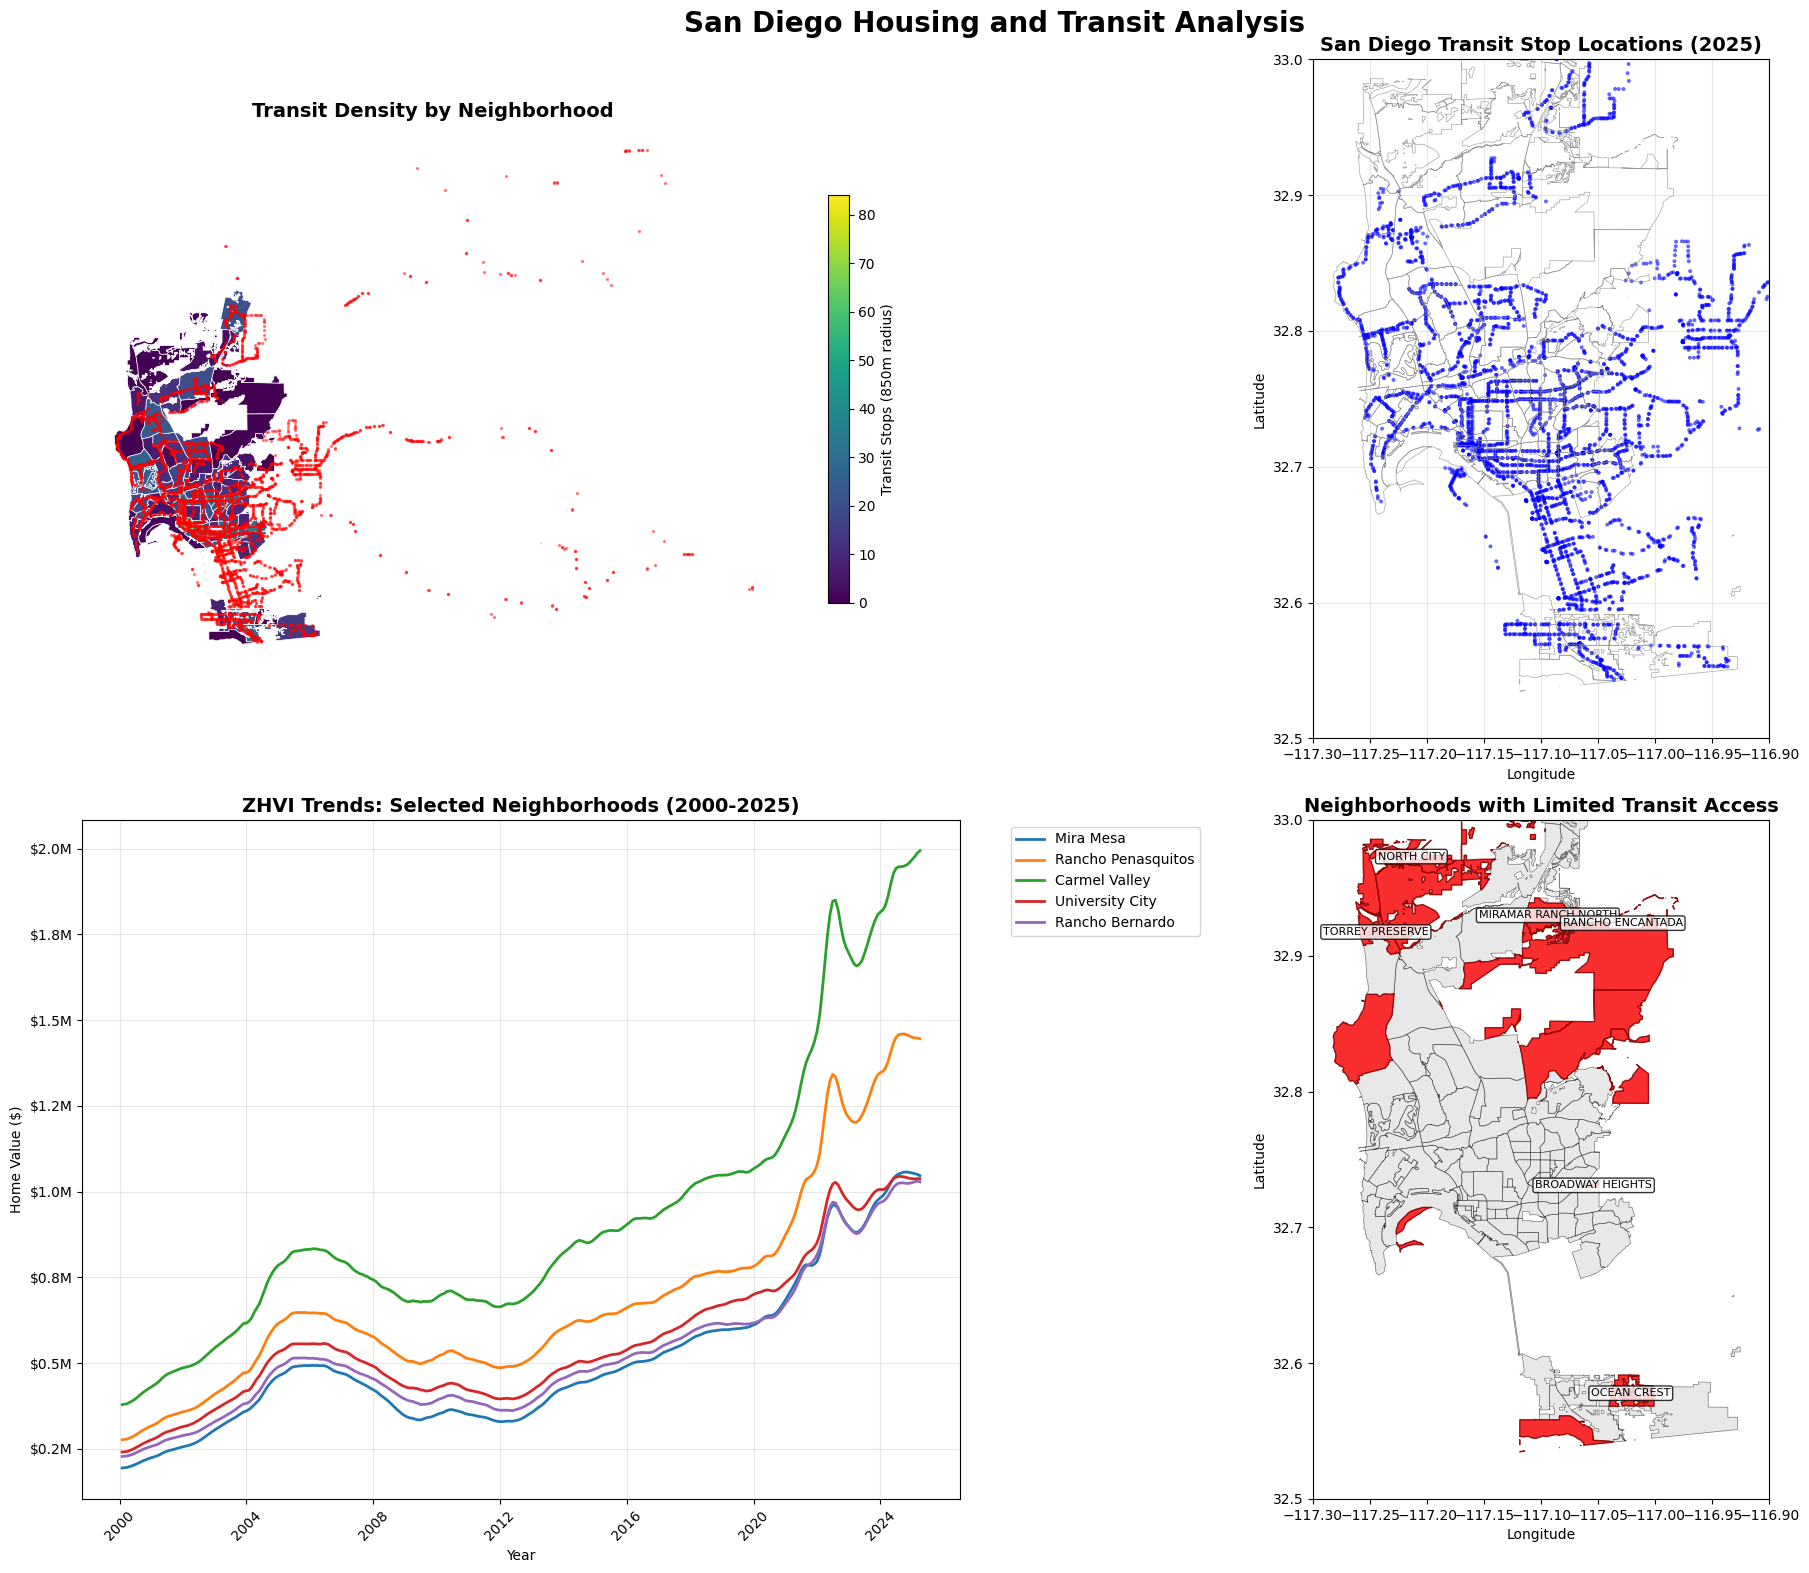

All visualizations completed!

 Quick Verification:
   Transit stops: 4394 loaded
   ZHVI data: 113 neighborhoods
   Neighborhood boundaries: 135 areas
   Zero transit areas: 18
   Latest ZHVI date: 2025-03-31
   Coordinate systems: Transit=EPSG:26911, Neighborhoods=Available


In [10]:
# FIXED COMPLETE VISUALIZATION - Replace your visualization cell with this

print("Creating fixed integrated visualization...")

# Create figure with proper sizing
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('San Diego Housing and Transit Analysis', fontsize=20, fontweight='bold')

# MAP 1: Transit Density by Neighborhood (FIXED)
print("   Creating Map 1: Transit Density...")
ax1 = axes[0, 0]
if 'neighborhoods_cleaned' in locals() and neighborhoods_cleaned is not None:
    # Plot neighborhoods with transit density
    neighborhoods_cleaned.plot(
        column="stop_count_850m", 
        cmap="viridis", 
        legend=True, 
        ax=ax1,
        edgecolor='white',
        linewidth=0.5,
        legend_kwds={'label': 'Transit Stops (850m radius)', 'shrink': 0.6}
    )
    # Overlay transit stops (smaller, more transparent)
    transit_gdf.plot(ax=ax1, color='red', markersize=2, alpha=0.4)
    ax1.set_title('Transit Density by Neighborhood', fontsize=14, fontweight='bold')
else:
    ax1.text(0.5, 0.5, 'Neighborhood shapefiles\nnot available', 
             ha='center', va='center', transform=ax1.transAxes, fontsize=12)
    ax1.set_title('Transit Density (Requires Shapefiles)', fontsize=14)
ax1.axis('off')

# MAP 2: Transit Stop Distribution (FIXED)
print("   Creating Map 2: Transit Stop Distribution...")
ax2 = axes[0, 1]
# Convert to geographic coordinates for proper display
transit_display = transit_gdf.to_crs(epsg=4326)
# Plot transit stops
ax2.scatter(transit_display.geometry.x, transit_display.geometry.y, 
           c='blue', s=8, alpha=0.6, edgecolors='none')

# Add neighborhood boundaries if available  
if 'neighborhoods_cleaned' in locals() and neighborhoods_cleaned is not None:
    neighborhoods_display = neighborhoods_cleaned.to_crs(epsg=4326)
    neighborhoods_display.plot(ax=ax2, facecolor='none', edgecolor='gray', 
                              alpha=0.7, linewidth=0.5)

ax2.set_title('San Diego Transit Stop Locations (2025)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.grid(True, alpha=0.3)
# Set proper axis limits for San Diego
ax2.set_xlim(-117.3, -116.9)
ax2.set_ylim(32.5, 33.0)

# MAP 3: ZHVI Trends (FIXED)
print("   Creating Map 3: ZHVI Trends...")
ax3 = axes[1, 0]
selected_neighborhoods = ['Mira Mesa', 'Rancho Penasquitos', 'Carmel Valley', 'University City', 'Rancho Bernardo']
zhvi_subset = zhvi_df[zhvi_df['RegionName'].isin(selected_neighborhoods)]

if not zhvi_subset.empty:
    # Prepare data for plotting
    date_columns = [col for col in zhvi_df.columns if col not in ['RegionID', 'SizeRank', 'RegionName']]
    zhvi_melted = zhvi_subset.melt(
        id_vars=['RegionName'], 
        value_vars=date_columns,
        var_name='Date', 
        value_name='ZHVI'
    )
    zhvi_melted['Date'] = pd.to_datetime(zhvi_melted['Date'])
    zhvi_melted = zhvi_melted.dropna()
    
    # Plot trends with different colors
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    for i, neighborhood in enumerate(selected_neighborhoods):
        data = zhvi_melted[zhvi_melted['RegionName'] == neighborhood]
        if not data.empty:
            ax3.plot(data['Date'], data['ZHVI'], 
                    label=neighborhood, linewidth=2, color=colors[i % len(colors)])
else:
    ax3.text(0.5, 0.5, 'No ZHVI data available\nfor selected neighborhoods', 
             ha='center', va='center', transform=ax3.transAxes, fontsize=12)

ax3.set_title('ZHVI Trends: Selected Neighborhoods (2000-2025)', fontsize=14, fontweight='bold')
ax3.set_xlabel('Year')
ax3.set_ylabel('Home Value ($)')
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='x', rotation=45)
# Format y-axis to show values in millions
ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))

# MAP 4: Limited Transit Access (FIXED)
print("   Creating Map 4: Limited Transit Access...")
ax4 = axes[1, 1]
if 'neighborhoods_cleaned' in locals() and neighborhoods_cleaned is not None:
    # Get neighborhoods with no transit
    no_transit = neighborhoods_cleaned[neighborhoods_cleaned['stop_count_850m'] == 0]
    all_neighborhoods = neighborhoods_cleaned.copy()
    
    # Convert to geographic coordinates
    no_transit_geo = no_transit.to_crs(epsg=4326)
    all_neighborhoods_geo = all_neighborhoods.to_crs(epsg=4326)
    
    # Plot all neighborhoods in light gray
    all_neighborhoods_geo.plot(ax=ax4, facecolor='lightgray', edgecolor='black', 
                              alpha=0.5, linewidth=0.5)
    
    # Highlight zero-transit neighborhoods in red
    if not no_transit_geo.empty:
        no_transit_geo.plot(ax=ax4, facecolor='red', edgecolor='darkred', 
                           alpha=0.8, linewidth=1)
        
        # Add labels for some areas (limit to prevent overcrowding)
        labeled_count = 0
        for idx, row in no_transit_geo.iterrows():
            if row['NAME'] and row['NAME'] != 'None' and labeled_count < 6:
                centroid = row.geometry.centroid
                ax4.annotate(row['NAME'], (centroid.x, centroid.y), 
                           fontsize=8, ha='center', va='center',
                           bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))
                labeled_count += 1
    
    # Set proper axis limits
    ax4.set_xlim(-117.3, -116.9)
    ax4.set_ylim(32.5, 33.0)
else:
    ax4.text(0.5, 0.5, 'Neighborhood shapefiles\nnot available', 
             ha='center', va='center', transform=ax4.transAxes, fontsize=12)

ax4.set_title('Neighborhoods with Limited Transit Access', fontsize=14, fontweight='bold')
ax4.set_xlabel('Longitude')
ax4.set_ylabel('Latitude')

# Adjust layout and display
plt.tight_layout()
plt.show()

print("All visualizations completed!")

# Quick verification
print(f"\n Quick Verification:")
print(f"   Transit stops: {len(transit_gdf)} loaded")
print(f"   ZHVI data: {len(zhvi_df)} neighborhoods")
if 'neighborhoods_cleaned' in locals() and neighborhoods_cleaned is not None:
    print(f"   Neighborhood boundaries: {len(neighborhoods_cleaned)} areas")
    print(f"   Zero transit areas: {len(neighborhoods_cleaned[neighborhoods_cleaned['stop_count_850m'] == 0])}")
else:
    print("   Neighborhood boundaries: Not loaded")
print(f"   Latest ZHVI date: {latest_zhvi_col}")
print(f"   Coordinate systems: Transit={transit_gdf.crs}, Neighborhoods={'Available' if 'neighborhoods_cleaned' in locals() and neighborhoods_cleaned is not None else 'N/A'}")

## Summary Analysis

In [9]:
# Summary Statistics
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)

print(f"\nTransit Infrastructure:")
print(f"  Total MTS Transit Stops: {len(transit_gdf)}")

if neighborhoods_cleaned is not None:
    print(f"  Total Neighborhoods Analyzed: {len(neighborhoods_cleaned)}")
    print(f"  Neighborhoods with No Transit Access: {len(neighborhoods_cleaned[neighborhoods_cleaned['stop_count_850m'] == 0])}")
    print(f"  Average Transit Stops per Neighborhood: {neighborhoods_cleaned['stop_count_850m'].mean():.1f}")
    print(f"  Max Transit Stops in Single Neighborhood: {neighborhoods_cleaned['stop_count_850m'].max():.0f}")
    
    print(f"\nNeighborhoods with Zero Transit Access:")
    zero_transit = neighborhoods_cleaned[neighborhoods_cleaned['stop_count_850m'] == 0]
    for idx, row in zero_transit.iterrows():
        if row['NAME'] and row['NAME'] != 'None':
            print(f"  - {row['NAME']}")

print(f"\nHousing Market (ZHVI):")
print(f"  Total Neighborhoods with ZHVI Data: {len(zhvi_df)}")
print(f"  Latest ZHVI Date: {latest_zhvi_col}")

if not zhvi_latest.empty:
    print(f"  Median Home Value (Latest): ${zhvi_latest['ZHVI_Latest'].median():,.0f}")
    print(f"  Highest Home Value: ${zhvi_latest['ZHVI_Latest'].max():,.0f}")
    print(f"  Lowest Home Value: ${zhvi_latest['ZHVI_Latest'].min():,.0f}")

print("\n" + "="*60)


SUMMARY STATISTICS

Transit Infrastructure:
  Total MTS Transit Stops: 4394
  Total Neighborhoods Analyzed: 135
  Neighborhoods with No Transit Access: 18
  Average Transit Stops per Neighborhood: 18.1
  Max Transit Stops in Single Neighborhood: 84

Neighborhoods with Zero Transit Access:
  - NORTH CITY
  - MIRAMAR RANCH NORTH
  - RANCHO ENCANTADA
  - BROADWAY HEIGHTS
  - TORREY PRESERVE
  - OCEAN CREST
  - LAKE MURRAY
  - DEL MAR HEIGHTS
  - CARMEL VALLEY
  - LA JOLLA
  - SCRIPPS RANCH
  - TIERRASANTA
  - MIRAMAR
  - BLACK MOUNTAIN RANCH
  - TORREY HIGHLANDS
  - SAN PASQUAL
  - TIJUANA RIVER VALLEY

Housing Market (ZHVI):
  Total Neighborhoods with ZHVI Data: 113
  Latest ZHVI Date: 2025-03-31
  Median Home Value (Latest): $863,806
  Highest Home Value: $2,792,695
  Lowest Home Value: $455,145

